In [1]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


# Importing Packages

In [3]:
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
import albumentations as A
from glob import glob
from PIL import Image
from pathlib import Path

import albumentations as A

from tqdm import tqdm

import cv2

Copying files: 487 files [05:51,  1.38 files/s]


In [ ]:
def check_for_corrupted_files(tb_folder, non_tb_folder):
    for filename in tqdm(os.listdir(tb_folder)):
        if filename.endswith('.png'):
            try:
                img = Image.open(os.path.join(tb_folder, filename))
                img.verify() # verify that it is, in fact an image
            except (IOError, SyntaxError) as e:
                print('Bad file:', filename) # print out the names of corrupt files

    for filename in tqdm(os.listdir(non_tb_folder)):
        if filename.endswith('.png'):
            try:
                img = Image.open(os.path.join(non_tb_folder, filename))
                img.verify() # verify that it is, in fact an image
            except (IOError, SyntaxError) as e:
                print('Bad file:', filename) # print out the names of corrupt files

In [ ]:
check_for_corrupted_files('../../data/tuberculosis-detection-model/original/TB', '../../data/tuberculosis-detection-model/original/non-TB')


## Creating Train and Validation Datasets

In [ ]:
def create_train_val_test_datasets(root_dir, output_dir):

    # # Create directories for training, validation sets.
    # for folder in ['train', 'val', 'test]:
    #     for cls in ['Non-TB', 'TB']:
    #         os.makedirs(os.path.join(output_dir, folder, cls))

    # Creating partitions of the data after shuffling.
    current_cls = 'Non-TB'
    src = os.path.join(root_dir, current_cls)
    all_file_names_0 = os.listdir(src)
    np.random.shuffle(all_file_names_0)
    train_file_names_0, val_file_names_0, test_file_names_0 = np.split(np.array(all_file_names_0), 
                                                                    [int(len(all_file_names_0) * 0.8), int(len(all_file_names_0) * 0.9)])

    train_file_names_0 = [os.path.join(src, name) for name in train_file_names_0.tolist()]
    val_file_names_0 = [os.path.join(src, name) for name in val_file_names_0.tolist()]
    test_file_names_0 = [os.path.join(src, name) for name in test_file_names_0.tolist()]

    # Move the images to the corresponding folders in the output directory.
    for file_name in tqdm(train_file_names_0):
        shutil.copy(file_name, os.path.join(output_dir, 'train', current_cls))

    for file_name in tqdm(val_file_names_0):
        shutil.copy(file_name, os.path.join(output_dir, 'val', current_cls))

    for file_name in tqdm(test_file_names_0):
        shutil.copy(file_name, os.path.join(output_dir, 'test', current_cls))

    # Move to the next class
    current_cls = 'TB'
    src = os.path.join(root_dir, current_cls)  # Folder to copy images from.
    all_file_names_1 = os.listdir(src)
    np.random.shuffle(all_file_names_1)
    train_file_names_1, val_file_names_1, test_file_names_1 = np.split(np.array(all_file_names_1), 
                                                                    [int(len(all_file_names_1) * 0.8), int(len(all_file_names_1) * 0.9)])
    train_file_names_1 = [os.path.join(src, name) for name in train_file_names_1.tolist()]
    val_file_names_1 = [os.path.join(src, name) for name in val_file_names_1.tolist()]
    test_file_names_1 = [os.path.join(src, name) for name in test_file_names_1.tolist()]

    # Move the images to the corresponding folders in the output directory.
    for file_name in tqdm(train_file_names_1):
        shutil.copy(file_name, os.path.join(output_dir, 'train', current_cls))

    for file_name in tqdm(val_file_names_1):
        shutil.copy(file_name, os.path.join(output_dir, 'val', current_cls))

    for file_name in tqdm(test_file_names_1):
        shutil.copy(file_name, os.path.join(output_dir, 'test', current_cls))

    all_file_names = all_file_names_0 + all_file_names_1
    train_file_names = train_file_names_0 + train_file_names_1
    val_file_names = val_file_names_0 + val_file_names_1

    print('Total images: ', len(all_file_names))
    print('Training: ', len(train_file_names))
    print('Validation: ', len(val_file_names))

In [7]:
create_train_val_test_datasets('data/Tuberculosis/original', 'data/Tuberculosis/original_sorted')

In [12]:
import splitfolders

input_folder = '../../data/tuberculosis-detection-model/original'
output_folder = '../../data/tuberculosis-detection-model/original_sorted'
splitfolders.ratio(input_folder, output_folder, seed=42, ratio=(0.8, 0.1, 0.1))

Copying files: 10343 files [39:09,  4.40 files/s]


## Creating augmented dataset

In [14]:
root_dir = '../../data/tuberculosis-detection-model/original_sorted/train/TB'

In [15]:
full_paths = glob('../../data/tuberculosis-detection-model/original_sorted/train/TB/*.png')
filenames = os.listdir('../../data/tuberculosis-detection-model/original_sorted/train/TB')

/Users/examsherpa/anaconda3/envs/mlp-env/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1284: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
100%|██████████| 1870/1870 [11:50<00:00,  2.63it/s]


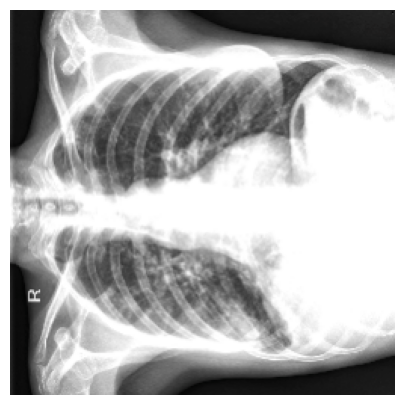

In [16]:
# defining augmentation pipeline
transform = A.Compose([
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomContrast(limit=0.3, p=0.5),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=0.3),
    A.OneOf([
        A.OpticalDistortion(distort_limit=1.0),
        A.GridDistortion(num_steps=5, distort_limit=1.0),
        A.ElasticTransform(alpha=3),
    ], p=0.3),
    A.CLAHE(clip_limit=4.0, p=0.3),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, border_mode=0, p=0.4),
    A.Resize(256, 256)
])

def visualize(image):
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(image)

image = cv2.imread(full_paths[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
transformed = transform(image=image)
aug_img = transformed['image']
aug_img = cv2.resize(aug_img, (255, 255))
visualize(aug_img)

for i in tqdm(range(0, len(full_paths))):
    image = cv2.imread(full_paths[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transformed = transform(image=image)
    aug_img = transformed['image']
    aug_img = cv2.resize(aug_img, (255, 255))
    cv2.imwrite(os.path.join(root_dir, f"augmentations/aug_{filenames[i][:-3]}.png"), aug_img)

In [6]:
# Define directory
root_dir = '/drive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/augmented'
output_dir = '/drive/MyDrive/Datasets/Omdena Myanmar/tuberculosis-detection-model/augmented/output'

# Create directories for training, validation sets.
for folder in ['train', 'val']:
    for cls in ['Non-Tuberculosis', 'Tuberculosis']:
        os.makedirs(os.path.join(output_dir, folder, cls))

# Creating partitions of the data after shuffling.
current_cls = 'Non-Tuberculosis'
src = os.path.join(root_dir, current_cls)
all_file_names_0 = os.listdir(src)
np.random.shuffle(all_file_names_0)
train_file_names_0, val_file_names_0 = np.split(np.array(all_file_names_0), [int(len(all_file_names_0) * 0.8)])
train_file_names_0 = [os.path.join(src, name) for name in train_file_names_0.tolist()]
val_file_names_0 = [os.path.join(src, name) for name in val_file_names_0.tolist()]

# Move the images to the corresponding folders in the output directory.
for file_name in tqdm(train_file_names_0):
    shutil.copy(file_name, os.path.join(output_dir, 'train', current_cls))

for file_name in tqdm(val_file_names_0):
    shutil.copy(file_name, os.path.join(output_dir, 'val', current_cls))

# Move to the next class
current_cls_1 = 'Tuberculosis'
src_1 = os.path.join(root_dir, current_cls_1)  # Folder to copy images from.
tb_file_names = ['Tuberculosis/' + str(x) for x in os.listdir(src_1)]

current_cls_2 = 'Augmented TB'
src_2 = os.path.join(root_dir, current_cls_2)  # Folder to copy images from.
aug_tb_file_names = ['Augmented TB/' + str(x) for x in os.listdir(src_2)]

all_file_names_1 = tb_file_names + aug_tb_file_names
np.random.shuffle(all_file_names_1)
train_file_names_1, val_file_names_1 = np.split(np.array(all_file_names_1), [int(len(all_file_names_1) * 0.8)])
train_file_names_1 = [os.path.join(root_dir, name) for name in train_file_names_1.tolist()]
val_file_names_1 = [os.path.join(root_dir, name) for name in val_file_names_1.tolist()]

# Move the images to the corresponding folders in the output directory.
for file_name in tqdm(train_file_names_1):
    shutil.copy(file_name, os.path.join(output_dir, 'train', current_cls))

for file_name in tqdm(val_file_names_1):
    shutil.copy(file_name, os.path.join(output_dir, 'val', current_cls))

all_file_names = all_file_names_0 + all_file_names_1
train_file_names = train_file_names_0 + train_file_names_1
val_file_names = val_file_names_0 + val_file_names_1

print('Total images: ', len(all_file_names))
print('Training: ', len(train_file_names))
print('Validation: ', len(val_file_names))

100%|██████████| 931/931 [00:29<00:00, 31.23it/s]

Total images:  12213
Training:  9770
Validation:  2443
